<a href="https://colab.research.google.com/github/CarlosVaquero/BudgetBuddy/blob/main/tijl_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/CarlosVaquero/BudgetBuddy/

Cloning into 'BudgetBuddy'...
remote: Enumerating objects: 918, done.
remote: Counting objects: 100% (918/918), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 918 (delta 66), reused 914 (delta 64), pack-reused 0 (from 0)
Receiving objects: 100% (918/918), 504.58 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [98]:
!pip install langchain_community
!pip install langchain-google-genai
!pip install langchain-chroma
!pip install faiss-cpu
!pip install -U langgraph

In [136]:
import os
import getpass
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display, Markdown
import textwrap
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver


In [110]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## Define the LLM to use

In [111]:
# Create LLM model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_retries=2
)

## Create the vector store

### Add ing.nl data

In [112]:
# Specify the directory
directory = 'BudgetBuddy/data/ingnl'

# Create an empty list to store file paths
file_paths = []

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Join the root directory with the file name to get the full path
        full_path = os.path.join(root, file)
        # Append the full path to the list
        file_paths.append(full_path)

In [113]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.
documents = []
for file_path in file_paths:
    documents.extend(TextLoader(file_path).load())
# text_splitter = CharacterTextSplitter(chunk_size=1000000, chunk_overlap=0)
# documents = text_splitter.split_documents(raw_documents)

In [114]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
vector_store_path = "BudgetBuddy/vectorstore/faiss_index"
try:
    #db_chroma = Chroma.from_documents(documents, embeddings)
    db_faiss = FAISS.load_local(
        vector_store_path, embeddings, allow_dangerous_deserialization=True
    )
    print("Loaded vector store from file")
except Exception:
    db_faiss = FAISS.from_documents(documents, embeddings)
    db_faiss.save_local(vector_store_path)
    print("Saved vector store to file")


Loaded vector store from file


In [56]:
query = "Kan ik mijn creditcard transacties zien in Kijk Vooruit?"
docs = db_faiss.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)

Document 1:
# Creditcard rekeningoverzicht in Mijn ING en de Mobiel Bankieren App - ING

### Waarom zie ik niet dezelfde transacties als mijn partner?

Heb je een extra creditcard? Dan zie je altijd alleen de transacties die met die creditcard gedaan zijn. De transacties van je partner zie je niet terug in je rekeningoverzicht. Hierdoor kan het zijn dat het saldo niet lijkt te kloppen. Wat je ziet is het actuele beschikbare saldo voor beide creditcards. De hoofdkaarthouder ziet op zijn beurt wel alle transacties in het overzicht terug, ook die met de extra creditcard zijn gedaan. Met welke creditcard de transactie is gedaan zie je aan de laatste 4 cijfers die bij de transactie staan.
Houd er rekening mee dat je alleen het creditcard rekeningoverzicht ziet van de persoon die is ingelogd in de Mobiel Bankieren App of Mijn ING. Indien je een gezamenlijke rekening hebt, dan is de maandelijkse afschrijving inzichtelijk voor beide rekeninghouders.
Document 2:
# Creditcard rekeningoverzicht i

### Create the Vector Database Retriever tool

In [115]:
retriever = db_faiss.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)

In [116]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ingnl_information",
    "Search and return information about (banking) products of ING, and features in the ING app that customers have available.",
)

### Create a Tavily Search tool

In [117]:
search_tool = TavilySearchResults(max_results=2)
search_tool.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

## Combine all the tools

In [118]:
tools = [retriever_tool, search_tool]
tools_names = {t.name: t for t in tools}
model = model.bind_tools(tools)

### Some helper functions

In [131]:
def wrap_text(text, width=100):
    text_split = text.split("\n")
    wrapped_text = textwrap.fill(text_split[0], width)
    if len(text_split) > 1:
        for line in text_split[1:]:
            wrapped_text += "\n" + textwrap.fill(line, width)
    return wrapped_text

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(wrap_text(message.pretty_repr()))

def ask(agent, question, config=None, verbose=False):
    messages = [HumanMessage(content=question)]
    if verbose:
        print_stream(agent.stream({"messages": messages}, config=config, stream_mode= "values"))
    else:
        result = agent.invoke({"messages": messages}, config=config)
        display(Markdown(wrap_text(result['messages'][-1].content)))

## Create the agent

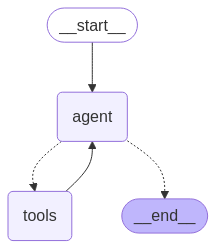

In [152]:
prompt = """
    You are a helpful assistant representing ING bank.
    Your goal is to find a satisfying answer to each question of a customer.
    You can assume that any human asking you a question, is an ING customer.
    If necessary, decompose the question into multiple tasks, and try
    to use the tools at your disposal to answer the subtasks before coming
    up with the final answer.
    Don't ask the user for confirmation.
    Just do stuff.
    Try to pitch features or products of ING inside your answers when that would
    be potentially benefitial for the customer. Only do that when that pitch is
    relevant to the question asked by the customer or the answer you came up with.
"""

memory = MemorySaver()
agent = create_react_agent(model, tools, prompt=prompt, checkpointer=memory)
display(Image(agent.get_graph().draw_mermaid_png()))

In [153]:
config = {"configurable": {"thread_id": "2"}}
ask(agent, "Welke transacties zie ik allemaal in Kijk Vooruit?", config=config)

In Kijk Vooruit zie je de volgende transacties:

*   Afschrijvingen die zeker gaan gebeuren.
*   Afschrijvingen die voorspeld worden op basis van eerdere afschrijvingen, zoals je
energierekening.
*   Bijschrijvingen die voorspeld worden op basis van eerdere bijschrijvingen, zoals je salaris.
*   Spaaropdrachten die je hebt ingepland.
*   Het voorspelde saldo op basis van alle bedragen die van je rekening afgaan of erbij komen.

Met Kijk Vooruit krijg je een beter beeld van wat je nog kunt besteden en voorkom je vervelende
verrassingen.

Wist je dat je in de ING app ook je transacties kunt taggen? Zo kun je specifieke uitgaven, zoals
cadeautjes, makkelijk terugvinden.

In [154]:
ask(agent, "Wie is Elon Musk?", config=config)

Elon Reeve Musk is een in de VS gevestigde internet- en ruimtelanseringsondernemer. Hij is geboren
op 28 juni 1971 in Pretoria, Zuid-Afrika.

In [157]:
ask(agent, "Hoe kan ik mijn maandelijkse kosten verlagen zonder mijn levensstijl te veel te veranderen?", config=config, verbose=True)

================================ Human Message =================================

Hoe kan ik mijn maandelijkse kosten verlagen zonder mijn levensstijl te veel te veranderen?
================================== Ai Message ==================================

Om je maandelijkse kosten te verlagen zonder je levensstijl drastisch te veranderen, zijn er
verschillende strategieën die je kunt toepassen. Hier zijn enkele tips:

1.  **Budgettering en inzicht:**
    *   **Maak een budget:** Begin met het opstellen van een gedetailleerd budget. Noteer al je
inkomsten en uitgaven. Dit geeft je een helder beeld van waar je geld naartoe gaat.
    *   **Gebruik de ING app:** De ING app heeft een functie genaamd "Inzicht" die automatisch je
uitgaven categoriseert. Dit helpt je om snel te zien waar je het meeste geld aan uitgeeft.
    *   **Kijk Vooruit:** Gebruik de "Kijk Vooruit" functie in de ING app om inzicht te krijgen in
je toekomstige inkomsten en uitgaven. Zo kun je beter plannen en onverwachte 

In [156]:
ask(agent, "Can you translate that to English?", config=config)

To lower your monthly expenses without drastically changing your lifestyle, consider the following
steps:

1.  **Analyze your spending:** Review your bank statements and credit card statements to see where
your money is going. Categorize your expenses into fixed costs (rent/mortgage, insurance,
subscriptions) and variable costs (groceries, entertainment, eating out). The ING app has a handy
feature called 'Insights' that can help you with this. This feature automatically categorizes your
expenses, allowing you to quickly see where your money is going.
2.  **Identify small savings:** Look for small, unobtrusive ways to save. For example:

    *   **Subscriptions:** Cancel subscriptions that you don't use or hardly use (streaming
services, magazines, gym).
    *   **Energy:** Turn the heating down a degree, shower shorter, and turn off the lights when you
leave a room.
    *   **Groceries:** Plan your meals, make a shopping list, and avoid impulse purchases. Choose
store brands instead of expensive name brands.
    *   **Eating out and take-out:** Limit the number of times you eat out or order food. Cook at
home more often.
    *   **Transportation:** Consider taking the bike or public transport more often instead of the
car.
3.  **Renegotiate contracts:** Contact your providers (internet, telephone, insurance) and ask if
they can offer a better deal. Often they are willing to give you a discount to prevent you from
switching to a competitor.
4.  **Automate your savings:** Set up an automatic transfer from your checking account to your
savings account. This way you automatically save a fixed amount per month without having to think
about it. With ING you can easily open savings accounts and set up automatic transfers.
5.  **Take advantage of offers and discounts:** Pay attention to offers and discounts at the stores
you visit regularly. Use discount codes for online purchases.
6.  **Look Ahead:** Use the "Look Ahead" feature in the ING app. This feature gives you insight into
your future income and expenses, so you can plan better and avoid surprises.

By following these steps, you can lower your monthly expenses without drastically changing your
lifestyle.

In [149]:
ask(agent, "Hoe zou ik kunnen zien waar mijn geld naartoe gaat?", config=config)

Er zijn verschillende manieren om te zien waar je geld naartoe gaat:

1.  **Bankafschriften en creditcardoverzichten:** Dit is de meest directe manier. Bekijk je
maandelijkse afschriften van je bankrekening(en) en creditcard(s). De meeste banken bieden
tegenwoordig online toegang, waardoor je gemakkelijk je transacties kunt bekijken en downloaden.
2.  **Budgetteringsapps:** Er zijn veel budgetteringsapps beschikbaar die automatisch je transacties
categoriseren en je een overzicht geven van je uitgaven. Voorbeelden zijn Mint, YNAB (You Need A
Budget), Personal Capital, en Goodbudget. Sommige banken hebben ook ingebouwde budgetteringstools in
hun apps.
3.  **Spreadsheet:** Als je liever zelf de controle houdt, kun je een spreadsheet (bijvoorbeeld in
Excel of Google Sheets) gebruiken om je inkomsten en uitgaven bij te houden. Je kunt je transacties
handmatig invoeren en categoriseren.
4.  **Contant geld bijhouden:** Als je veel contant geld gebruikt, kan het lastiger zijn om je
uitgaven bij te houden. Je kunt een klein notitieboekje of een app gebruiken om elke contante
uitgave te noteren.
5.  **Bankieren app functies:** Veel banken bieden tegenwoordig functies in hun apps die je helpen
inzicht te krijgen in je uitgaven. Ze categoriseren automatisch je transacties en geven je
overzichten van je uitgaven per categorie.

**Tips voor het analyseren van je uitgaven:**

*   **Categoriseer je uitgaven:** Verdeel je uitgaven in categorieën zoals wonen, transport, eten,
entertainment, kleding, etc.
*   **Identificeer patronen:** Kijk of er bepaalde patronen zijn in je uitgaven. Geef je
bijvoorbeeld veel geld uit aan uit eten gaan in het weekend?
*   **Stel prioriteiten:** Bepaal welke uitgaven noodzakelijk zijn en welke optioneel.
*   **Wees eerlijk:** Wees eerlijk tegen jezelf over je uitgaven. Het is belangrijk om een
realistisch beeld te krijgen van waar je geld naartoe gaat.

Door je uitgaven op deze manieren te analyseren, kun je inzicht krijgen in je bestedingspatroon en
gebieden identificeren waar je kunt besparen.